# Finite differences

This notebook is part of the EOAS 555 Non-linear interpolation course by Eldad Haber.

In [1]:
import os, sys
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

We start by codeing the first derivative matrix. A finite difference matrix from the
nodes to the cell centers.
$$ (Du)_{i+1/2} = {\frac 1h} (u_{i+1} - u_i) $$

In [2]:
def DxNodeToCell(h, n):
    diagonals = [-np.ones(n+1)/h, np.ones(n+1)/h]
    Dx = sparse.spdiags(diagonals, [0, 1], n,n+1)
    return Dx

We now test the code on a simple function

h =  0.125 average error =  0.10468861190812412
h =  0.0625 average error =  0.025818171198255746
h =  0.03125 average error =  0.006432756335899705
h =  0.015625 average error =  0.0016068326198611814
h =  0.0078125 average error =  0.00040162345673459246
h =  0.00390625 average error =  0.00010040057180516181


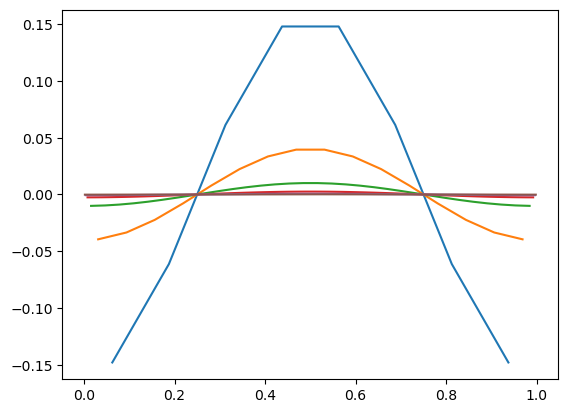

In [3]:
for i in range(6):
    n = 2**(i+3)
    h = 1.0/n
    # nodal grid
    x = np.linspace(0, n, n+1)*h

    # cell centered grid
    xc = x[:-1] + h/2 

    u = np.sin(2*np.pi*x)
    D = DxNodeToCell(h,n)

    up = D@u
    up_true = 2*np.pi*np.cos(2*np.pi*xc)

    r = up-up_true
    print('h = ',h, 'average error = ',np.absolute(r).mean())
    plt.plot(xc, r)


Next we code a finite difference matrix from the cells to the nodes

In [4]:
# Note the boundary condition
#                           (uG - un)/h
# x ---0---x---0---x ---0 ---x---G
# but uG = -un

def DxCellToNode(h, n):
    d1 = -np.ones(n)/h
    d1[-1] = -2/h
    d2 = np.ones(n)/h
    d2[0] = 2/h
    diagonals = [d1, d2]
    Dx = sparse.spdiags(diagonals, [-1, 0], n+1,n)
    return Dx

In [5]:
A = DxCellToNode(1, 5).toarray()
print(A)

[[ 2.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.]
 [ 0.  0. -1.  1.  0.]
 [ 0.  0.  0. -1.  1.]
 [ 0.  0.  0.  0. -2.]]


h =  0.125 average error =  0.10377863510773433
h =  0.0625 average error =  0.026202842300844666
h =  0.03125 average error =  0.006513494347764476
h =  0.015625 average error =  0.001619021675760613
h =  0.0078125 average error =  0.000403280036488708
h =  0.00390625 average error =  0.000100616015246868


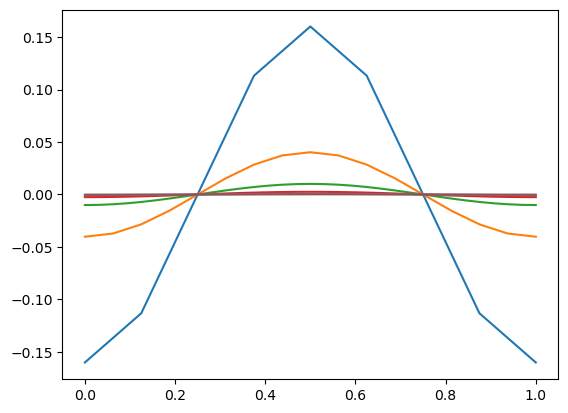

In [6]:
# Testing - note boundary conditions!!!

for i in range(6):
    n = 2**(i+3)
    h = 1.0/n
    # nodal grid
    x = np.linspace(0, n, n+1)*h
    # cell centered grid
    xc = x[:-1] + h/2 

    u = np.sin(2*np.pi*xc)
    D = DxCellToNode(h, n)

    up = D@u
    up_true = 2*np.pi*np.cos(2*np.pi*x)

    r = up-up_true
    print('h = ',h, 'average error = ',np.absolute(r).mean())
    plt.plot(x, r)

In [7]:
# Mass matrix
def getMassMatrix(sig):
    n = len(sig)
    M = sparse.spdiags(sig, 0, n,n)
    return M

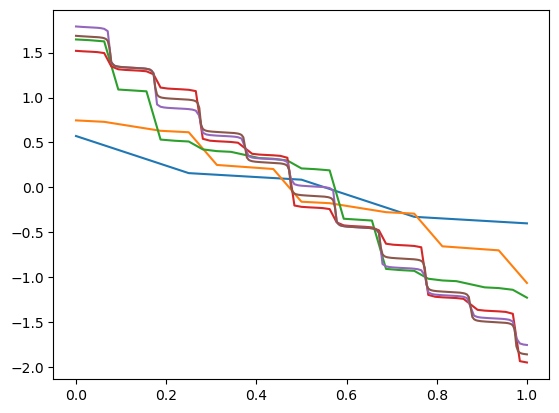

In [8]:
# Now lets put it all together
for j in range(6):
    n = 2**(3+j)
    h = 1/n
    # nodal grid
    x = np.linspace(0, n, n+1)*h
    # cell centered grid
    xc = x[:-1] + h/2 

    # Periodic media
    sig = np.sin(20*np.pi*xc) + 1.01
    #sig = np.exp(-3*xc)+0.01

    Dnc = DxNodeToCell(h, n)
    Dcn = DxCellToNode(h, n)
    M   = getMassMatrix(sig)

    # Combine matrices
    A = Dcn@(M@Dnc) + 1e-2*sparse.eye(n+1)

    # define a source on the nodes
    q = np.zeros(n+1)
    q[0] = -1.0/h
    q[-1] = 1.0/h

    from scipy.sparse.linalg import spsolve
    u = spsolve(A, q)

    plt.plot(x, u)